<a href="https://colab.research.google.com/github/CristianCosci/LAB_MachineLearning_course/blob/main/LSTM_Tesla_Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Model


**Getting the stock price history data**

load the data and inspect it:

In [45]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TSLA.csv")

print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


 **Load the data and inspect them**

In [54]:
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values
print(training_set[:5])

[[52.444   ]
 [52.450001]
 [52.419998]
 [53.348   ]
 [52.844002]]


**normalize and reshape**

We want our data to be in the form of a 3D array for our LSTM model. First, we create data in 60 timesteps and convert it into an array using NumPy. Then, we convert the data into a 3D array with X_train samples, 60 timestamps, and one feature at each step.

In [99]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train2 = np.array([training_set_scaled[:,:][i : i + 60] for i in range(len(training_set_scaled) - 60)])
X_train = []

y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60 : i, 0])
    y_train.append(training_set_scaled[i, 0])

# [10, 20, 3, 40, 50, 60, 70, 80]
# timestamps = 3
# r1 = [10, 20, 30] -> y_1 = 40
# r2 = [20, 30, 40] -> y_2 = 50
# r3 = [30, 40, 50] -> y_3 = 60 and so on..

X_train, y_train = np.array(X_train), np.array(y_train)
# [samples, timestamps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape)
print(X_train2.shape)
print(y_train.shape)
# #print(X_train[0])
# #(740, 60, 1)

(740, 60, 1)
(740, 60, 1)
(740,)


In [ ]:
X_train - X_train2 # they are the same

**Now, it’s time to build the model**

Add LSTM layer along with dropout layers to prevent overfitting. After that, we add a Dense layer that specifies a one unit output. Next, we compile the model using the adam optimizer and set the loss as the mean_squarred_error


In [101]:
#DO with GRU also
model = Sequential()#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))# Adding the output layer
model.add(Dense(1)) # no activation because we are working with values

# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mse')

#add checkpoint to save model

# Fitting the LSTM to the Training set
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
24/24 [==============================] - 11s 129ms/step - loss: 0.0606
Epoch 2/10
24/24 [==============================] - 4s 153ms/step - loss: 0.0158
Epoch 3/10
24/24 [==============================] - 4s 149ms/step - loss: 0.0137
Epoch 4/10
24/24 [==============================] - 3s 128ms/step - loss: 0.0128
Epoch 5/10
24/24 [==============================] - 3s 132ms/step - loss: 0.0120
Epoch 6/10
24/24 [==============================] - 3s 128ms/step - loss: 0.0140
Epoch 7/10
24/24 [==============================] - 3s 131ms/step - loss: 0.0109
Epoch 8/10
24/24 [==============================] - 3s 131ms/step - loss: 0.0115
Epoch 9/10
24/24 [==============================] - 3s 122ms/step - loss: 0.0098
Epoch 10/10
24/24 [==============================] - 3s 130ms/step - loss: 0.0105


**Prepare the test data (reshape them)**

In [102]:
# Getting the predicted stock price for testing
dataset_train = df.iloc[:800, 1:2]
dataset_train.to_csv("dataset_train.csv")
dataset_test = df.iloc[800:, 1:2]
dataset_test.to_csv("dataset_test.csv")

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
print(dataset_total.shape)

inputs = dataset_total[len(dataset_total) - len(dataset_test) -60 :].values
inputs = inputs.reshape(-1,1)
print(inputs.shape)

inputs = sc.transform(inputs)
X_test = []

for i in range(60, 519):
    X_test.append(inputs[i-60 : i ,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# # (459, 60, 1)

(1259, 1)
(519, 1)
(459, 60, 1)


**Make Predictions using the test set**

In [103]:
predicted_stock_price = model.predict(X_test)
print(predicted_stock_price.shape)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(predicted_stock_price[:3])

(459, 1)
[[61.25789 ]
 [60.561142]
 [59.881332]]


**Visualize the results**

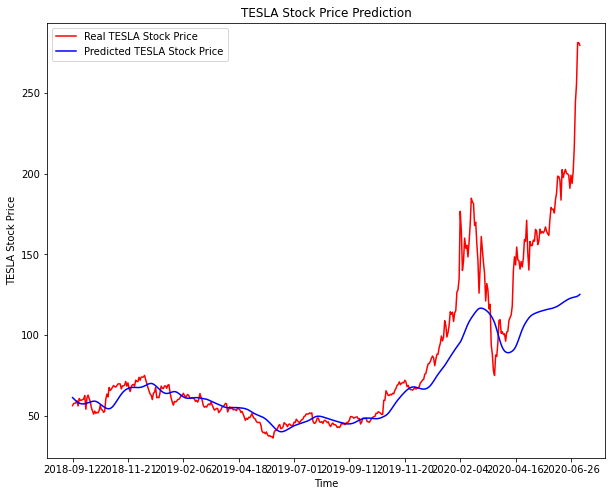

In [104]:
# Visualising the results
plt.figure(figsize=(10,8))
plt.plot(df.loc[800:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price, color = "blue", label = "Predicted TESLA Stock Price")
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

**Observation**: Huge drop in March 2020 due to the COVID-19 lockdown !

We can clearly see that our model performed very good. It is able to accuretly follow most of the unexcepted jumps/drops however, for the most recent date stamps, we can see that the model expected (predicted) lower values compared to the real values of the stock price.

**Prepare data for a MLP model**

In [105]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled_nn = sc.fit_transform(training_set)# Creating a data structure with 60 time-steps and 1 output
X_train_nn = []
y_train_nn = []

for i in range(60, 800):
    X_train_nn.append(training_set_scaled_nn[i-60:i, 0])
    y_train_nn.append(training_set_scaled_nn[i, 0])

X_train_nn, y_train_nn = np.array(X_train_nn), np.array(y_train_nn)

print(X_train_nn.shape, y_train_nn.shape)


(740, 60) (740,)


**MLP model**

In [106]:
model_nn = keras.Sequential()
model_nn.add(Dense(256, activation='relu', input_dim=60)) #input_shape
model_nn.add(Dense(512, activation='relu'))
model_nn.add(Dense(256, activation='relu')) 
model_nn.add(Dense(128, activation='relu')) 
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(1))

model_nn.compile(optimizer='adam',loss='mean_squared_error')
model_nn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               15616     
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 319,745
Trainable params: 319,745
Non-tr

In [107]:
model_nn.fit(X_train_nn,y_train_nn,epochs=10,batch_size=32)

Epoch 1/10
24/24 [==============================] - 1s 6ms/step - loss: 0.0251
Epoch 2/10
24/24 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 3/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0044
Epoch 5/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 6/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 7/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 8/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 9/10
24/24 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 10/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0025


**Prepare test set for MLP model**

In [108]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test_nn = []
for i in range(60, 519):
    X_test_nn.append(inputs[i-60:i, 0])
X_test_nn = np.array(X_test_nn)

print(X_test_nn.shape)

(459, 60)


In [109]:
predicted_stock_price_nn_init = model_nn.predict(X_test_nn)
predicted_stock_price_nn = sc.inverse_transform(predicted_stock_price_nn_init)

print(predicted_stock_price_nn[:3])

[[50.25243 ]
 [50.117752]
 [51.31677 ]]


**Visualize the results**

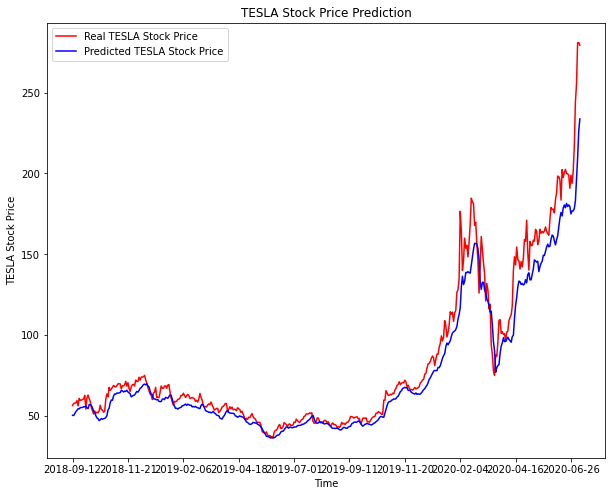

In [110]:
# Visualising the results
plt.figure(figsize=(10,8))
plt.plot(df.loc[800:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price_nn, color = "blue", label = "Predicted TESLA Stock Price")
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

**Multi step predictions**


[10, 20, 30, 40, 50, 60, 70, 80, 90]

input : [10,20,30]
output: [40,50]

In [111]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)# Creating a data structure with 60 time-steps and 2 steps into the future
X_train = []
y_train = []

for i in range(60, 800-2):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i: i+2, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(y_train[0])
print(X_train.shape[0], X_train.shape[1], X_train.shape[2])

[0.43589644 0.39972175]
738 60 1


In [113]:
model = Sequential()#Adding the first LSTM layer and some Dropout regularisation 
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))       #n_features is still 1. each time time is represented by 1 number only
                                                                                                #n_steps_in = X_train.shape[1]

model.add(Dropout(0.2))# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))# Adding the output layer
model.add(Dense(2)) #n_steps_out = 2 

# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the LSTM to the Training set
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
24/24 [==============================] - 12s 132ms/step - loss: 0.0778
Epoch 2/10
24/24 [==============================] - 3s 132ms/step - loss: 0.0198
Epoch 3/10
24/24 [==============================] - 4s 150ms/step - loss: 0.0157
Epoch 4/10
24/24 [==============================] - 4s 148ms/step - loss: 0.0151
Epoch 5/10
24/24 [==============================] - 3s 122ms/step - loss: 0.0142
Epoch 6/10
24/24 [==============================] - 3s 134ms/step - loss: 0.0133
Epoch 7/10
24/24 [==============================] - 3s 139ms/step - loss: 0.0136
Epoch 8/10
24/24 [==============================] - 3s 145ms/step - loss: 0.0132
Epoch 9/10
24/24 [==============================] - 3s 138ms/step - loss: 0.0116
Epoch 10/10
24/24 [==============================] - 3s 143ms/step - loss: 0.0126


**Prepare the test set**

In [114]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


**Make predictions**

In [115]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(predicted_stock_price.shape)
print(predicted_stock_price[:3])

(459, 2)
[[58.401924 59.645824]
 [57.76279  59.001152]
 [57.131466 58.355312]]


**Visualize the results**

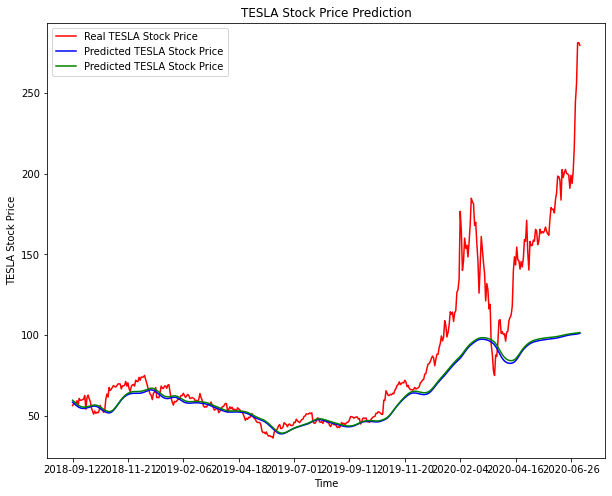

In [116]:
# Visualising the results
plt.figure(figsize=(10,8))
plt.plot(df.loc[800:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price[:,0], color = "blue", label = "Predicted TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price[:,1], color = "green", label = "Predicted TESLA Stock Price")

plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

**Multivariate**

In [117]:
#multivariate
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [118]:
df["average"] = (df["High"] + df["Low"])/2
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,average
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500,52.081998
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500,51.859999
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000,52.650002
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000,52.957000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000,53.036000


**Prepare the training data**

In [119]:
input_features =  df.iloc[:800,[6,7]].values
input_features[:5]

array([[1.30545000e+07, 5.20819985e+01],
       [1.48015000e+07, 5.18599985e+01],
       [9.53800000e+06, 5.26500015e+01],
       [1.01080000e+07, 5.29570005e+01],
       [8.08000000e+06, 5.30359995e+01]])

In [120]:
print(input_features[:5,1])

[52.0819985 51.8599985 52.6500015 52.9570005 53.0359995]


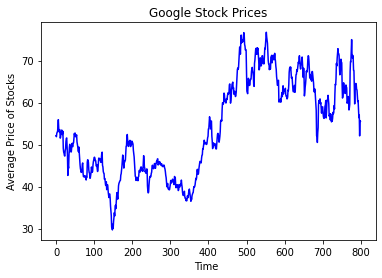

In [121]:
plt.plot(input_features[:,1], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time ")
plt.ylabel("Average Price of Stocks")
plt.show()

**Normalize**

In [122]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_features_scaled = sc.fit_transform(input_features)

print(input_features_scaled[:5,1])
input_features_scaled[:7]

[0.47624206 0.47152448 0.48831233 0.49483618 0.49651493]


array([[0.06307719, 0.47624206],
       [0.07465907, 0.47152448],
       [0.03976425, 0.48831233],
       [0.04354312, 0.49483618],
       [0.03009832, 0.49651493],
       [0.1424068 , 0.52505424],
       [0.14155822, 0.55777978]])

**Split data in sequences**

In [123]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)- n_steps -1):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y) 
 
X, y = split_sequences(input_features_scaled,3)

In [124]:
print(X[0], y[0])

[[0.06307719 0.47624206]
 [0.07465907 0.47152448]
 [0.03976425 0.48831233]] 0.49483617562543913


In [125]:
print(X[1], y[1])

[[0.07465907 0.47152448]
 [0.03976425 0.48831233]
 [0.04354312 0.49483618]] 0.4965149337358694


In [126]:
print(X[2], y[2])

[[0.03976425 0.48831233]
 [0.04354312 0.49483618]
 [0.03009832 0.49651493]] 0.5250542359954287


**Split and Reshape**

In [127]:
X, y = split_sequences(input_features_scaled,60)
X, y= np.array(X), np.array(y)

# X = X.reshape()

print(X.shape)


(739, 60, 2)


**Build LSTM for multivariate case**

In [129]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=30, return_sequences= True, input_shape=(X.shape[1], X.shape[2])))
model.add(keras.layers.LSTM(units=30, return_sequences= True))
model.add(keras.layers.LSTM(units=30))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model.fit(X, y, epochs=20, batch_size=32)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 60, 30)            3960      
                                                                 
 lstm_28 (LSTM)              (None, 60, 30)            7320      
                                                                 
 lstm_29 (LSTM)              (None, 30)                7320      
                                                                 
 dense_13 (Dense)            (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
24/24 [==============================] - 8s 76ms/step - loss: 0.0577
Epoch 2/20
24/24 [==============================] - 2s 75ms/step - loss: 0.0106
Epoch 3/20
24/24 [====

**Prepare testing set**

In [130]:
input_features_test =  df.iloc[800:,[6,7]].values
input_features_test[:5]
#normalization
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_features_test_scaled = sc.fit_transform(input_features_test)

print(input_features_test_scaled[:5,1])
input_features_test_scaled[:7]

X_test, y_test = split_sequences(input_features_test_scaled,60)
print(X_test.shape, y_test.shape)

predicted_value= model.predict(X_test)

[0.08635861 0.09011713 0.09164468 0.09378824 0.08926802]
(398, 60, 2) (398,)


**Visualize**

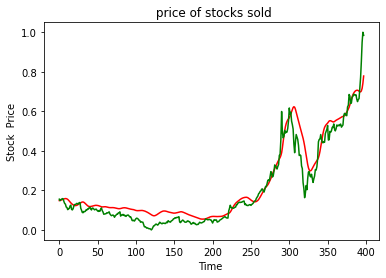

In [131]:
plt.plot(predicted_value, color= 'red')
plt.plot(y_test, color='green')
plt.title(" price of stocks sold")
plt.xlabel("Time ")
plt.ylabel("Stock  Price")
plt.show()

**Multivariate multistep: to do as homework**